# Installing Necessary Libraries

In [1]:
pip install selenium beautifulsoup4 webdriver-manager

Note: you may need to restart the kernel to use updated packages.


# Scraping LinkedIn Job Data

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import pandas as pd

# Setting up the Chrome WebDriver 
driver = webdriver.Chrome()

# Defining the job roles I want to search for
job_roles = ['data%20analyst', 'business%20analyst', 'data%20science']

# Defining the location for the job search
location = 'India'

# Initialize an empty list to store job data
job_data = []

# Loopping through job roles
for role in job_roles:
    # Defining base LinkedIn job search URL for each role
    base_url = f'https://www.linkedin.com/jobs/search/?keywords={role}&location={location}&start='
    
    # Loopping through multiple pages 
    for page in range(0, 200, 25): 
        print(f"Scraping {role.replace('%20', ' ').title()} jobs, page: {page // 25 + 1}")
        
        # Constructing URL for the current page
        url = base_url + str(page)
        driver.get(url)
        
        # Letting the page load completely
        time.sleep(10)
        
        # Getting the page source and parse with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        
        # Extracting job listings from the left pane
        jobs = soup.find_all('div', class_='base-card')
        
        # Extracting job details
        for job in jobs:
            # Extract the title (handle NoneType)
            title_tag = job.find('h3', class_='base-search-card__title')
            title = title_tag.text.strip() if title_tag else 'Title not specified'
            
            # Extracting the company (handle NoneType)
            company_tag = job.find('h4', class_='base-search-card__subtitle')
            company = company_tag.text.strip() if company_tag else 'Company not specified'
            
            # Extracting the location (handle NoneType)
            location_tag = job.find('span', class_='job-search-card__location')
            location = location_tag.text.strip() if location_tag else 'Location not specified'
            
            # Extracting the date posted (handle NoneType)
            date_tag = job.find('time', class_='job-search-card__listdate')
            date_posted = date_tag.text.strip() if date_tag else 'Not specified'
            
            # Extracting the job description (handle NoneType)
            description_tag = job.find('p', class_='job-search-card__snippet')
            job_description = description_tag.text.strip() if description_tag else 'No description'
            
            # Appending job details to job_data list
            job_data.append({
                'Role': role.replace('%20', ' ').title(),
                'Title': title,
                'Company': company,
                'Location': location,
                'Date Posted': date_posted,
                'Job Description': job_description
            })

# Closing the browser after scraping all pages
driver.quit()

# Converting to a DataFrame
df = pd.DataFrame(job_data)

# Displaying the final DataFrame shape and first few rows
print(df.shape)
print(df.head())



Scraping Data Analyst jobs, page: 1
Scraping Data Analyst jobs, page: 2
Scraping Data Analyst jobs, page: 3
Scraping Data Analyst jobs, page: 4
Scraping Data Analyst jobs, page: 5
Scraping Data Analyst jobs, page: 6
Scraping Data Analyst jobs, page: 7
Scraping Data Analyst jobs, page: 8
Scraping Business Analyst jobs, page: 1
Scraping Business Analyst jobs, page: 2
Scraping Business Analyst jobs, page: 3
Scraping Business Analyst jobs, page: 4
Scraping Business Analyst jobs, page: 5
Scraping Business Analyst jobs, page: 6
Scraping Business Analyst jobs, page: 7
Scraping Business Analyst jobs, page: 8
Scraping Data Science jobs, page: 1
Scraping Data Science jobs, page: 2
Scraping Data Science jobs, page: 3
Scraping Data Science jobs, page: 4
Scraping Data Science jobs, page: 5
Scraping Data Science jobs, page: 6
Scraping Data Science jobs, page: 7
Scraping Data Science jobs, page: 8
(778, 6)
           Role         Title          Company  \
0  Data Analyst  Data Analyst            Meri

# Storing the Data in CSV Format


In [4]:
import pandas as pd

# Converting the job data to a DataFrame
df = pd.DataFrame(job_data)

# Saving the DataFrame to a CSV file
df.to_csv('linkedin_jobs.csv', index=False)

print("Data saved to linkedin_jobs.csv")

Data saved to linkedin_jobs.csv


# DATA CLEANING

In [5]:
# 1. Removing Duplicates
df_cleaned = df.drop_duplicates()


In [7]:
# 2. Handling Missing Values
# a. Removing rows where 'Title', 'Company', or 'Location' is missing as these are important fields
df_cleaned = df_cleaned.dropna(subset=['Title', 'Company', 'Location'])

In [9]:
# 3. Standardize Inconsistent Data (e.g., company names or locations)
df_cleaned['Company'] = df_cleaned['Company'].str.upper()  # Standardize company names to uppercase


In [18]:
# 4. Dropping the 'Job Description' column from the DataFrame
df_cleaned = df_cleaned.drop(columns=['Job Description'])

# Verifying that the column is removed
print(df_cleaned.columns)


Index(['Role', 'Title', 'Company', 'Location', 'Date Posted'], dtype='object')


# Filtering out jobs posted more than 30 days ago:

In [10]:
import pandas as pd
from datetime import datetime, timedelta

# Defining a function to convert the 'Date Posted' text to actual number of days ago
def convert_to_days_ago(text):
    text = text.lower()  # Making the text lowercase for consistent processing
    
    if 'today' in text or 'just' in text:
        return 0
    elif 'day' in text:
        return int(text.split()[0])  # Extract number of days
    elif 'week' in text:
        return int(text.split()[0]) * 7  # Convert weeks to days
    elif 'month' in text:
        return int(text.split()[0]) * 30  # Convert months to days (approximation)
    elif 'year' in text:
        return int(text.split()[0]) * 365  # Convert years to days (approximation)
    else:
        return None  # Return None for unrecognized formats

# Applying the conversion function to the 'Date Posted' column
df['Days Ago'] = df['Date Posted'].apply(convert_to_days_ago)

# Dropping rows where 'Days Ago' is None (i.e., unrecognized date formats)
df_cleaned = df.dropna(subset=['Days Ago'])

# Filtering out jobs posted more than 30 days ago
df_cleaned = df_cleaned[df_cleaned['Days Ago'] <= 30]

# Optionally drop the 'Days Ago' column if no longer needed
df_cleaned = df_cleaned.drop(columns=['Days Ago'])

# Saving the cleaned DataFrame to a CSV file
df_cleaned.to_csv('linkedin_jobs_filtered.csv', index=False)

# Displaying the cleaned DataFrame
print(df_cleaned.shape)
print(df_cleaned.head())


(690, 6)
           Role         Title          Company  \
0  Data Analyst  Data Analyst            Meril   
1  Data Analyst  Data Analyst             Navi   
3  Data Analyst  Data Analyst              EXL   
4  Data Analyst       Analyst  Larsen & Toubro   
6  Data Analyst  Data Analyst            Wipro   

                            Location  Date Posted Job Description  
0       Kanpur, Uttar Pradesh, India   3 days ago  No description  
1  Bangalore Urban, Karnataka, India   5 days ago  No description  
3           Gurugram, Haryana, India  2 weeks ago  No description  
4         Mumbai Metropolitan Region   1 week ago  No description  
6        Hyderabad, Telangana, India  2 weeks ago  No description  


In [19]:
df_cleaned

,Role,Title,Company,Location,Date Posted
0,Data Analyst,Data Analyst,Meril,"Kanpur, Uttar Pradesh, India",3 days ago
1,Data Analyst,Data Analyst,Navi,"Bangalore Urban, Karnataka, India",5 days ago
3,Data Analyst,Data Analyst,EXL,"Gurugram, Haryana, India",2 weeks ago
4,Data Analyst,Analyst,Larsen & Toubro,Mumbai Metropolitan Region,1 week ago
6,Data Analyst,Data Analyst,Wipro,"Hyderabad, Telangana, India",2 weeks ago
...,...,...,...,...,...
772,Data Science,Data Scientist,IBM,"Bengaluru East, Karnataka, India",3 days ago
773,Data Science,Python Developer,Persistent Systems,"Bengaluru, Karnataka, India",4 days ago
775,Data Science,Data Scientist,Hexaware Technologies,"Bengaluru, Karnataka, India",1 week ago
776,Data Science,Applied Scientist,Microsoft,"Bengaluru, Karnataka, India",5 days ago


# Exploratory Data Analysis (EDA)

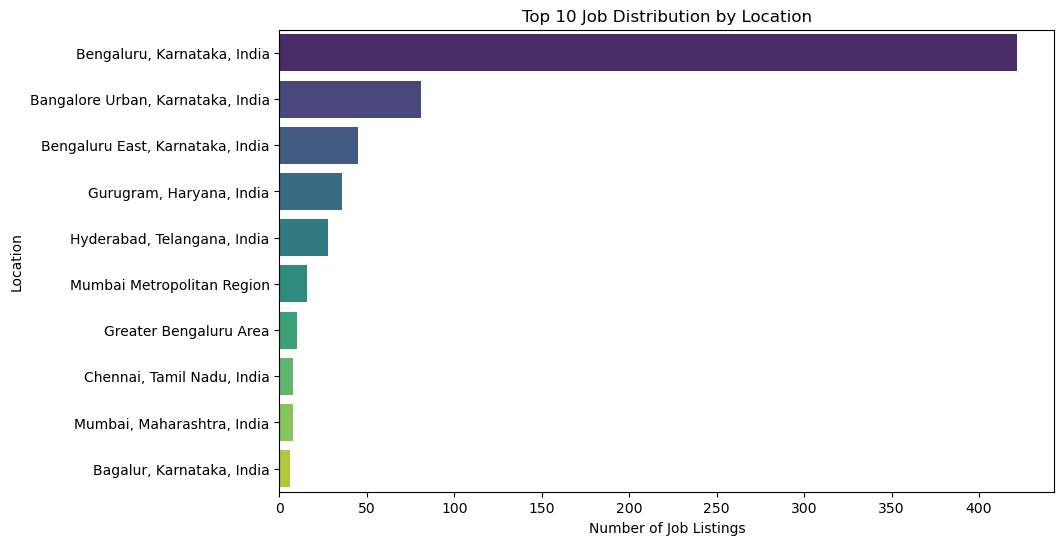

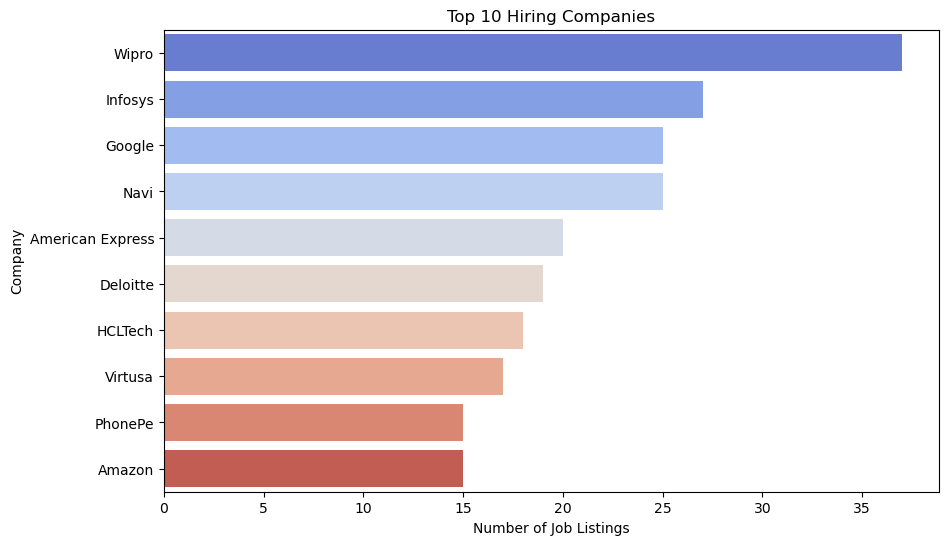

Descriptive Statistics for the Dataset:
                Role             Title Company                     Location  \
count            690               690     690                          690   
unique             3                68     100                           18   
top     Data Science  Business Analyst   Wipro  Bengaluru, Karnataka, India   
freq             324               126      37                          422   

       Date Posted  
count          690  
unique          10  
top     1 week ago  
freq           156  
Most common job titles:
Title
Business Analyst             126
Data Analyst                 110
Data Scientist               102
Business Data Analyst         18
Analyst-Data Science          16
Python Developer              12
Machine Learning Engineer     12
Senior Business Analyst       12
Marketing Analyst              6
Product Data Scientist         6
Name: count, dtype: int64
Most common locations:
Location
Bengaluru, Karnataka, India          422


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the cleaned dataset
df = pd.read_csv('linkedin_jobs_filtered.csv')

# 1. Job Distribution by Location
# Getting job count by location
location_counts = df_cleaned['Location'].value_counts().head(10)  # Top 10 locations

# Plotting Job Distribution by Location
plt.figure(figsize=(10, 6))
sns.barplot(x=location_counts.values, y=location_counts.index, palette='viridis')
plt.title('Top 10 Job Distribution by Location')
plt.xlabel('Number of Job Listings')
plt.ylabel('Location')
plt.show()

# 2. Top Hiring Companies
# Getting the top hiring companies
company_counts = df_cleaned['Company'].value_counts().head(10)  # Top 10 companies

# Plotting Top Hiring Companies
plt.figure(figsize=(10, 6))
sns.barplot(x=company_counts.values, y=company_counts.index, palette='coolwarm')
plt.title('Top 10 Hiring Companies')
plt.xlabel('Number of Job Listings')
plt.ylabel('Company')
plt.show()


# 3. Descriptive Statistics
# General statistics of the dataset
print("Descriptive Statistics for the Dataset:")
print(df_cleaned.describe(include='all'))

# Insights based on job titles and companies
print("Most common job titles:")
print(df_cleaned['Title'].value_counts().head(10))

print("Most common locations:")
print(df_cleaned['Location'].value_counts().head(10))